In [1]:
import math
from statistics import stdev
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df = df.resample('8H').agg( { 'open' : 'first' , 'high' : 'max' , 'low' : 'min'  , 'close' : 'last' , 'tickvol' : 'sum'  }  ).dropna()

Based on Oreilly 
https://www.oreilly.com/library/view/machine-learning-for/9781492085249/ch04.html

In [5]:
df['ret'] = abs(np.log( df['close'] / df['close'].shift(1) ) * 100)
df['realized_vol'] = df['ret'].rolling( 3 ).std( )* np.sqrt( 3 )
df['returns_svm'] = df['ret'] ** 2

df['target'] = abs( df['realized_vol'].shift( -1 ))

df = df.drop(   [ 'open' , 'high' , 'low' , 'close' , 'tickvol'  ]       , axis =  1).dropna()
df

,ret,realized_vol,returns_svm,target
datetime,,,,
2007-04-03 00:00:00,0.032118,0.041740,0.001032,0.309152
2007-04-03 08:00:00,0.352621,0.309152,0.124342,0.524969
2007-04-03 16:00:00,0.637961,0.524969,0.406994,0.430332
2007-04-04 00:00:00,0.142982,0.430332,0.020444,0.441171
2007-04-04 08:00:00,0.286169,0.441171,0.081893,0.143187
...,...,...,...,...
2023-10-19 08:00:00,0.186404,0.485732,0.034747,0.710417
2023-10-19 16:00:00,0.887786,0.710417,0.788164,0.799077
2023-10-20 00:00:00,0.017893,0.799077,0.000320,0.776236


In [6]:
X = df.loc[ : , [ 'returns_svm' , 'realized_vol'  ] ]
y = df.loc[ : , 'target' ]#.shift(-1)

In [7]:
X_train = X.loc[  : '2018'  ]
X_test = X.loc[ '2019' :   ]

y_train = y.loc[ : '2018'  ]
y_test = y.loc[ '2019' :   ]

In [8]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse

In [9]:
svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

In [10]:
para_grid = {'gamma': sp_rand(),
            'C': sp_rand(),
            'epsilon': sp_rand()}

clf = RandomizedSearchCV(svr_lin, para_grid) 

clf.fit(   X_train.values   ,  y_train.values.reshape( -1 , 1 )  )#.reshape( -1 , 1 )   ) 

predict_svr_lin = clf.predict(    X_test  ) 

predict_svr_lin = pd.DataFrame(  predict_svr_lin   )/100
predict_svr_lin.index = X_test.index

In [11]:
rmse_svr = np.sqrt(    mse(     y_test / 100  ,   predict_svr_lin.values      ) )
print('The RMSE value of SVR with Linear Kernel is {:.6f}'
    .format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.003829


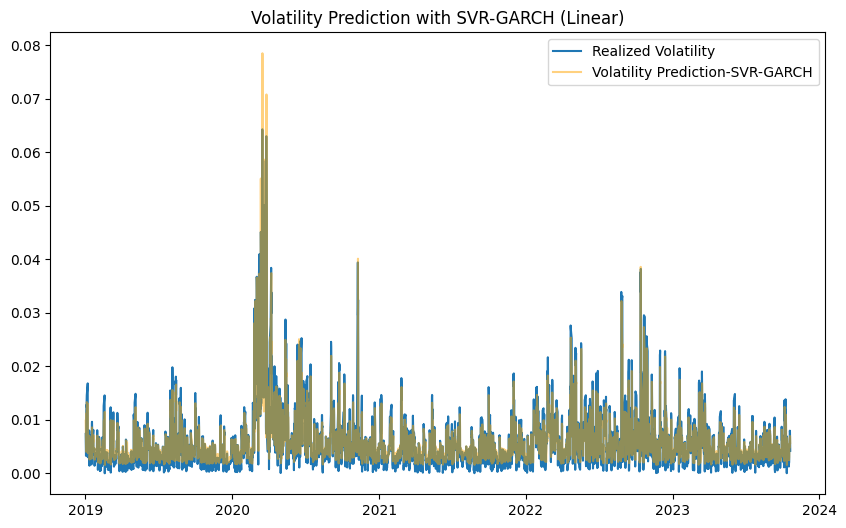

In [12]:
# realized_vol.index = ret.iloc[4:].index

plt.figure(   figsize=(10, 6)    )

plt.plot(   y_test /100  ,    label='Realized Volatility'     )


plt.plot(   predict_svr_lin   , label='Volatility Prediction-SVR-GARCH' , color = 'orange' , alpha = 0.5 )

plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

<Axes: xlabel='target', ylabel='0'>

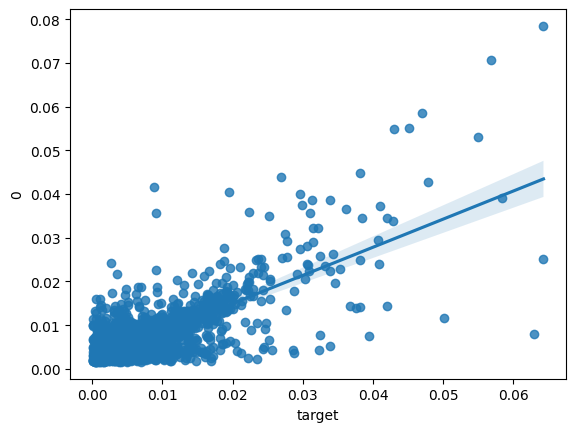

In [15]:
sns.regplot( x = y_test/100, y = predict_svr_lin  )